# Robotics, Vision & Control 3e: for Python
## Chapter 7: Robot Arm Kinematics

Copyright (c) 2021- Peter Corke

In [1]:
try:
    from google.colab import output
    print('Running on CoLab')
    output.enable_custom_widget_manager()
    !pip install ipympl
    !pip install roboticstoolbox-python>=1.0.2
    !pip install --no-deps rvc3python
    COLAB = True
except ModuleNotFoundError:
    COLAB = False

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"
from IPython.display import HTML

%matplotlib widget
import matplotlib.pyplot as plt

# add RTB examples folder to the path
import sys, os.path
import RVC3 as rvc
sys.path.append(os.path.join(rvc.__path__[0], 'models'))

# helper function to run bdsim in a subprocess and transfer results using a pickle file
import pickle
def run_shell(tool, **params):
    global out
    pyfile = os.path.join(rvc.__path__[0], "models", tool+".py")
    cmd = f"python {pyfile} -H +a -o"
    for key, value in params.items():
        cmd += f' --global "{key}={value}"'
    print(cmd)
    os.system(cmd)
    with open("bd.out", "rb") as f:
        out = pickle.load(f)
        
# ------ standard imports ------ #
import numpy as np
from scipy import optimize
import math
from math import pi
np.set_printoptions(
    linewidth=120, formatter={
        'float': lambda x: f"{0:8.4g}" if abs(x) < 1e-10 else f"{x:8.4g}"})
np.random.seed(0)
from spatialmath import *
from spatialmath.base import *
from roboticstoolbox import *

# 7.1 Forward Kinematics


## 7.1.1 Forward kinematics from a pose graph


### 7.1.1.1 2-Dimensional (Planar) Robotic Arms


In [2]:
# ETS stands for: Elementary transformation sequence, ET2 is for the 2-dimensional case
a1 = 1;
e = ET2.R() * ET2.tx(a1);

In [3]:
len(e)

2

In [4]:
e

R(q) ⊕ tx(1)


In [5]:
# for a particular value of the joint variable
e.fkine(pi / 6)

   0.866    -0.5       0.866     
   0.5       0.866     0.5       
   0         0         1         


In [6]:
# equal to the former one
SE2.Rot(pi / 6) * SE2.Tx(a1)

   0.866    -0.5       0.866     
   0.5       0.866     0.5       
   0         0         1         


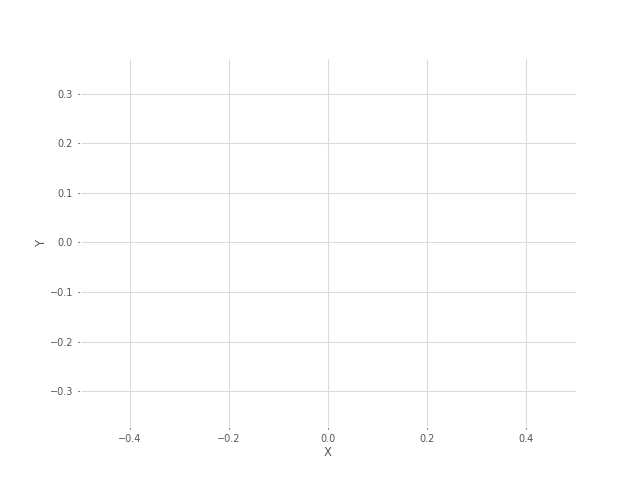

In [7]:
# e.teach(0)  # not working in Jupyter
e.plot(0)

In [23]:
# consider a robot has two revolute joints q_0 and q_1
a1 = 1; a2 = 2;
e = ET2.R() * ET2.tx(a1) * ET2.R() * ET2.tx(a2);

In [24]:
e

R(q0) ⊕ tx(1) ⊕ R(q1) ⊕ tx(2)


In [25]:
# evaluate this expression for specific joint angles, get the result of the end-effector pose when q_0=30 and q_1=40
e.fkine(np.deg2rad([30, 30])).printline()

t = 1.87, 2.23; 60°


In [26]:
T = SE2.Rot(np.deg2rad(30)) * SE2.Tx(a1) * SE2.Rot(np.deg2rad(30)) * SE2.Tx(a2);
T.printline()

t = 1.87, 2.23; 60°


In [27]:
# number of joints
e.n

2

In [28]:
# ET elements in the sequence that are joints
e.joints()

[R(q0), R(q1)]

In [29]:
# the joint structure of a robot (R for revolute and P for prismatic)
e.structure

'RR'

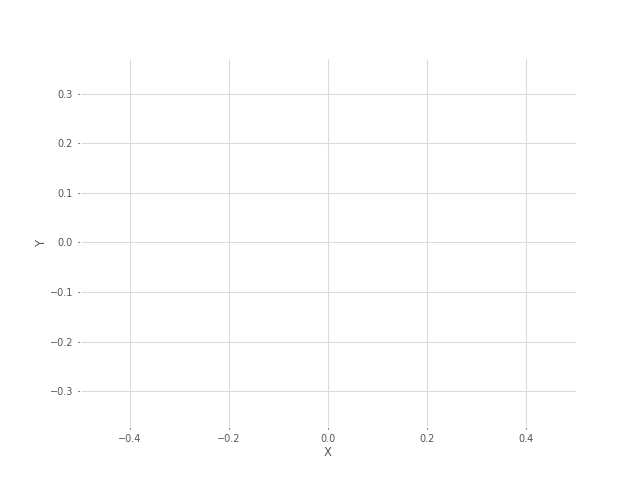

In [30]:
# display the robot nuninteracitvely
e.plot(np.deg2rad([30, 30]));

In [17]:
# ET2 object also acts like a list, we can slice it as follows
e[1]

tx(1)

In [19]:
# the transformation constant (a_1 in this case)
e[1].eta

1.0

In [20]:
# the corresponding SE(2) matrix (corresponding SE(2) matrix which in this case represents a translation of 1 in the x-direction)
e[1].A()

array([[       1,        0,        1],
       [       0,        1,        0],
       [       0,        0,        1]])

In [31]:
e[2]

R(q1)

In [33]:
e[3]

tx(2)

In [35]:
e[0]

R(q0)

In [32]:
e[2].A()

array([[       1,        0,        0],
       [       0,        1,        0],
       [       0,        0,        1]])

In [21]:
# a robot includes a prismatic joint. (for prismatic joint we need to specify the range of motion qlim)
e = ET2.R() * ET2.tx(qlim=[1,2])

R(q0) ⊕ tx(q1)


In [22]:
e.structure

'RP'

### 7.1.1.2 3-Dimensional Robotic Arms


In [40]:
a1 = 1; a2 = 1;
e = ET.Rz() * ET.Ry() \
     * ET.tz(a1) * ET.Ry() * ET.tz(a2) \
     * ET.Rz() * ET.Ry() * ET.Rz();

In [42]:
e.n

6

In [43]:
e.structure

'RRRRRR'

In [44]:
# end-effector pose for all zero joint angles 
e.fkine(np.zeros((6,)))

   1         0         0         0         
   0         1         0         0         
   0         0         1         2         
   0         0         0         1         


## 7.1.2 Forward kinematics as a chain of robot links


### 7.1.2.1 2-Dimensional (Planar) case


In [45]:
link1 = Link2(ET2.R(), name="link1");
link2 = Link2(ET2.tx(1) * ET2.R(), name="link2", parent=link1);
link3 = Link2(ET2.tx(1), name="link3", parent=link2);

In [46]:
robot = ERobot2([link1, link2, link3], name="my robot")

ERobot: my robot, 2 joints (RR)
┌─────┬────────┬───────┬────────┬─────────────────────┐
│link │  link  │ joint │ parent │ ETS: parent to link │
├─────┼────────┼───────┼────────┼─────────────────────┤
│   0 │ link1  │     0 │ BASE   │ R(q0)               │
│   1 │ link2  │     1 │ link1  │ tx(1) ⊕ R(q1)       │
│   2 │ @link3 │       │ link2  │ tx(1)               │
└─────┴────────┴───────┴────────┴─────────────────────┘

In [47]:
robot.fkine(np.deg2rad([30, 40])).printline()

t = 1.21, 1.44; 70°


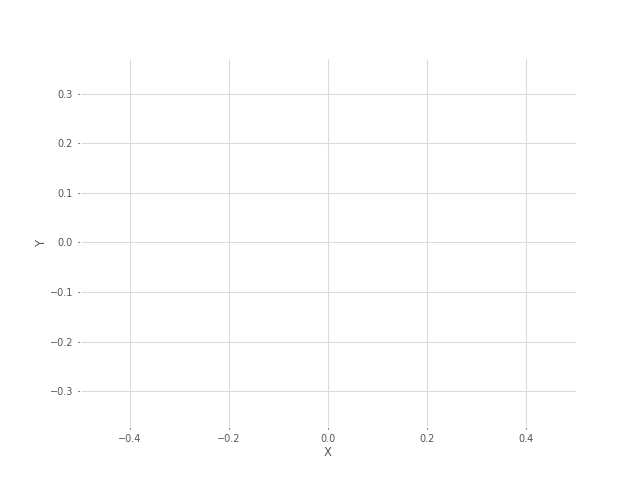

In [48]:
robot.plot(np.deg2rad([30, 40]));

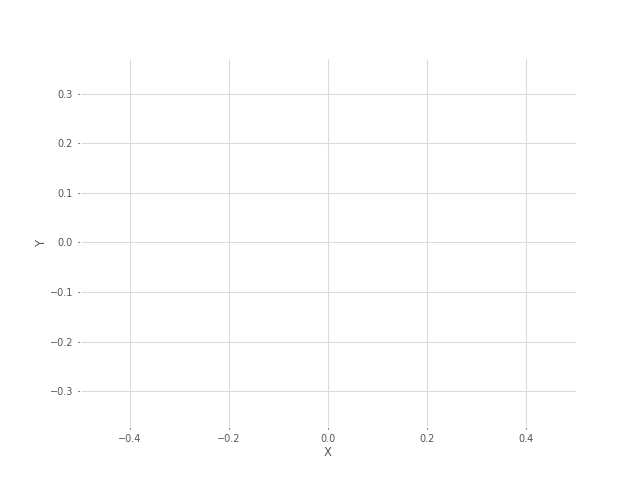

In [49]:
q = np.array([np.linspace(0, pi, 100), np.linspace(0, -2 * pi, 100)]).T;
q.shape
robot.plot(q);

In [50]:
# slice
robot[1]

Link2("link2", tx(1) ⊕ R(q), parent="link1")

In [51]:
# act as dictionary
robot["link2"]

Link2("link2", tx(1) ⊕ R(q), parent="link1")

In [52]:
# end effector
robot.ee_links

[Link2("link3", tx(1), parent="link2")]

In [53]:
# show its parent
link2.parent

Link2("link1", R(q))

In [54]:
# show its children
link2.children

[Link2("link3", tx(1), parent="link2")]

In [55]:
# show its joint index
link2.jindex

1

In [57]:
# test the type of joint
link2.isrevolute

True

In [58]:
# test the type of joint
link2.isprismatic

False

In [59]:
# joints can have upper and lower limits, but in this case none are set
print(link2.qlim)

None


In [60]:
# the relative pose of this link's frame with respect to its parent's frame
link2.A(pi / 6)

   0.866    -0.5       1         
   0.5       0.866     0         
   0         0         1         


In [ ]:
# evaluate the link's ETS
link2.ets

### 7.1.2.2 3-Dimensional case (HW2-Problem2.2)


In [62]:
a1 = 1; a2 = 1;
robot6 = ERobot(ET.Rz() * ET.Ry()\
                * ET.tz(a1) * ET.Ry() * ET.tz(a2)\
                * ET.Rz() * ET.Ry() * ET.Rz())

ERobot: , 6 joints (RRRRRR)
┌─────┬────────┬───────┬────────┬─────────────────────┐
│link │  link  │ joint │ parent │ ETS: parent to link │
├─────┼────────┼───────┼────────┼─────────────────────┤
│   0 │ link0  │     0 │ BASE   │ Rz(q0)              │
│   1 │ link1  │     1 │ link0  │ Ry(q1)              │
│   2 │ link2  │     2 │ link1  │ tz(1) ⊕ Ry(q2)      │
│   3 │ link3  │     3 │ link2  │ tz(1) ⊕ Rz(q3)      │
│   4 │ link4  │     4 │ link3  │ Ry(q4)              │
│   5 │ @link5 │     5 │ link4  │ Rz(q5)              │
└─────┴────────┴───────┴────────┴─────────────────────┘

In [63]:
models.list(type="ETS")

┌─────────────┬───────────────┬─────────────────────┬──────┬─────┬──────┬───────────┬──────────┬──────────┬──────────┐
│   class     │     name      │    manufacturer     │ type │ DoF │ dims │ structure │ dynamics │ geometry │ keywords │
├─────────────┼───────────────┼─────────────────────┼──────┼─────┼──────┼───────────┼──────────┼──────────┼──────────┤
│Panda        │ Panda         │ Franka Emika        │ ETS  │ 7   │ 3d   │ RRRRRRR   │          │          │          │
│Frankie      │ Frankie       │ Franka Emika, Omron │ ETS  │ 9   │ 3d   │ RPRRRRRRR │          │          │ mobile   │
│Puma560      │ Puma560       │ Unimation           │ ETS  │ 6   │ 3d   │ RRRRRR    │          │          │          │
│Planar_Y     │ Planar-Y      │                     │ ETS  │ 6   │ 3d   │ RRRRRR    │          │          │          │
│GenericSeven │ Generic Seven │ Jesse's Imagination │ ETS  │ 7   │ 3d   │ RRRRRRR   │          │          │          │
│XYPanda      │ XYPanda       │ Franka Emika    

In [64]:
panda = models.ETS.Panda()

ERobot: Panda (by Franka Emika), 7 joints (RRRRRRR)
┌─────┬───────┬───────┬────────┬─────────────────────────────────────────────┐
│link │ link  │ joint │ parent │             ETS: parent to link             │
├─────┼───────┼───────┼────────┼─────────────────────────────────────────────┤
│   0 │ link0 │     0 │ BASE   │ tz(0.333) ⊕ Rz(q0)                          │
│   1 │ link1 │     1 │ link0  │ Rx(-90°) ⊕ Rz(q1)                           │
│   2 │ link2 │     2 │ link1  │ Rx(90°) ⊕ tz(0.316) ⊕ Rz(q2)                │
│   3 │ link3 │     3 │ link2  │ tx(0.0825) ⊕ Rx(90°) ⊕ Rz(q3)               │
│   4 │ link4 │     4 │ link3  │ tx(-0.0825) ⊕ Rx(-90°) ⊕ tz(0.384) ⊕ Rz(q4) │
│   5 │ link5 │     5 │ link4  │ Rx(90°) ⊕ Rz(q5)                            │
│   6 │ link6 │     6 │ link5  │ tx(0.088) ⊕ Rx(90°) ⊕ tz(0.107) ⊕ Rz(q6)    │
│   7 │ @ee   │       │ link6  │ tz(0.103) ⊕ Rz(-45°)                        │
└─────┴───────┴───────┴────────┴─────────────────────────────────────────────┘


In [65]:
# pre-defined joint configurations named qr, as well as qz
panda.qr

array([       0,     -0.3,        0,     -2.2,        0,        2,   0.7854])

In [66]:
# add a configuration to this robot instance
panda.addconfiguration("foo", [1, 2, 3, 4, 5, 6, 7]) 

In [67]:
panda.configs["foo"];
panda.configs["qz"];

In [68]:
# compute the forward kinematics
panda.fkine(panda.qr).printline()

t = 0.484, 0, 0.413; rpy/zyx = 180°, -5.73°, 0°


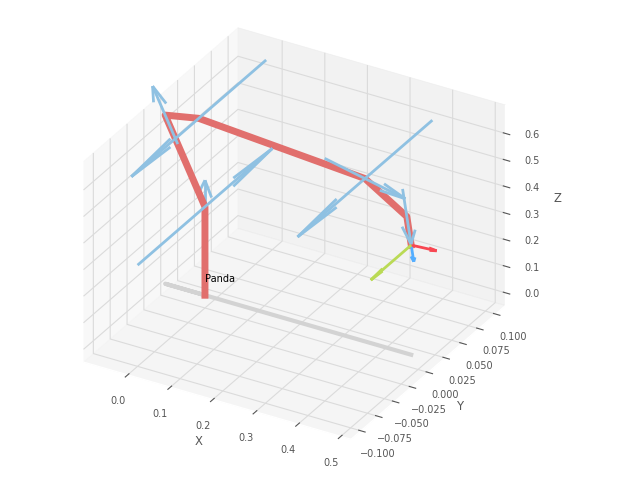

In [69]:
panda.plot(panda.qr);

In [70]:
# obtain all the link frames
T = panda.fkine_all(panda.qr);
len(T)

9

In [71]:
# the pose of the link 1 frame, and T[0] is the base frame, and T[8] is the tool frame.
T[1].printline()

t = 0, 0, 0.333; rpy/zyx = 0°, 0°, 0°


### 7.1.2.3 Tools and bases


In [72]:
# set the default base or tool of any Toolbox robot object
panda.base = SE3.Tz(3) * SE3.Rx(pi); # robot is 3m up and hanging down
panda.tool = SE3.Tz(0.15); # tool is 150mm long in z-direction

In [73]:
panda.fkine(panda.qr, tool=SE3.Trans(0.05, 0.02, 0.20) * SE3.Rz(np.deg2rad(45)));

## 7.1.3 Branched robots


### 7.1.3.1 2D (Planar) Branched robots


In [74]:
robot = ERobot2([
  Link2(ET2.R(), name="link1"),
  Link2(ET2.tx(1) * ET2.tx(1.2) * ET2.ty(-0.5) * ET2.R(), name="link2", parent="link1"),
  Link2(ET2.tx(1), name="ee_1", parent="link2"),
  Link2(ET2.tx(1) * ET2.tx(0.6) * ET2.ty(0.5) * ET2.R(), name="link3", parent="link1"),
  Link2(ET2.tx(1), name="ee_2", parent="link3") ], name="branched");

In [75]:
robot["link1"].children

[Link2("link2", tx(1) ⊕ tx(1.2) ⊕ ty(-0.5) ⊕ R(q), parent="link1"),
 Link2("link3", tx(1) ⊕ tx(0.6) ⊕ ty(0.5) ⊕ R(q), parent="link1")]

In [76]:
robot

ERobot: branched, 3 joints (RRR), 2 branches
┌─────┬───────┬───────┬────────┬────────────────────────────────────┐
│link │ link  │ joint │ parent │        ETS: parent to link         │
├─────┼───────┼───────┼────────┼────────────────────────────────────┤
│   0 │ link1 │     0 │ BASE   │ R(q0)                              │
│   1 │ link2 │     1 │ link1  │ tx(1) ⊕ tx(1.2) ⊕ ty(-0.5) ⊕ R(q1) │
│   2 │ @ee_1 │       │ link2  │ tx(1)                              │
│   3 │ link3 │     2 │ link1  │ tx(1) ⊕ tx(0.6) ⊕ ty(0.5) ⊕ R(q2)  │
│   4 │ @ee_2 │       │ link3  │ tx(1)                              │
└─────┴───────┴───────┴────────┴────────────────────────────────────┘

In [ ]:
robot.showgraph()

In [ ]:
# robot.teach()
plt.figure()
robot.plot([0.3, 0.4, -0.6]);

In [ ]:
robot.fkine([0.3, 0.4, -0.6], end="ee_2")

In [ ]:
robot.fkine([0.3, 0.4, -0.6], end="ee_2", start="ee_1")

## 7.1.4 Unified Robot Description Format (URDF)


In [ ]:
urdf, *_ = ERobot.URDF_read("ur_description/urdf/ur5_joint_limited_robot.urdf.xacro")
urdf

In [ ]:
ur5 = models.URDF.UR5()

In [ ]:
ur5.showgraph()

In [ ]:
ur5.grippers

In [ ]:
ur5.plot(ur5.qr);

In [ ]:
ur5.dynamics()

In [ ]:
yumi = models.URDF.YuMi()

In [ ]:
yumi.showgraph(ets="brief")

In [ ]:
yumi.grippers

In [ ]:
yumi.plot(yumi.q1);

In [ ]:
models.list(type="URDF")

In [ ]:
pr2 = models.URDF.PR2()

In [ ]:
pr2.showgraph()

In [ ]:
pr2.plot(pr2.qz)

## 7.1.5 Denavit-Hartenberg Parameters


In [ ]:
link = RevoluteDH(a=1)

In [ ]:
link.A(0.5)

In [ ]:
models.list(type="DH")

In [ ]:
irb140 = models.DH.IRB140();

In [ ]:
irb140

In [ ]:
irb140._tool

In [ ]:
irb140.fkine(irb140.qr).printline("rpy/xyz")

In [ ]:
irb140.plot(irb140.qr);

In [ ]:
# irb140.teach()

In [ ]:
irb140.ets()

# 7.2 Inverse Kinematics


## 7.2.1 2-Dimensional (Planar) Robotic Arms


### 7.2.1.1 Closed-Form Solution


In [ ]:
import sympy
a1, a2 = sympy.symbols("a1 a2")
e = ET2.R() * ET2.tx(a1) * ET2.R() * ET2.tx(a2);

In [ ]:
q0, q1 = sympy.symbols("q0 q1")

In [ ]:
TE = e.fkine([q0, q1])
x_fk, y_fk = TE.t;

In [ ]:
x, y = sympy.symbols("x y")

In [ ]:
eq1 = (x_fk**2 + y_fk**2 - x**2 - y**2).trigsimp()  

In [ ]:
q1_sol = sympy.solve(eq1, q1) 
eq0 = tuple(map(sympy.expand_trig, [x_fk - x, y_fk - y]))
q0_sol = sympy.solve(eq0, [sympy.sin(q0), sympy.cos(q0)]);

In [ ]:
sympy.atan2(q0_sol[sympy.sin(q0)], q0_sol[sympy.cos(q0)]).simplify()

### 7.2.1.2 Numerical Solution


In [ ]:
e = ET2.R() * ET2.tx(1) * ET2.R() * ET2.tx(1);

In [ ]:
pstar = np.array([0.6, 0.7]);  # desired position
E = lambda q: np.linalg.norm(e.fkine(q).t - pstar);

In [ ]:
sol = optimize.minimize(E, [0, 0]);

In [ ]:
sol.x

In [ ]:
e.fkine(sol.x).printline()

## 7.2.2 3-Dimensional Robotic Arms


### 7.2.2.1 Closed-Form Solution


In [ ]:
puma = models.DH.Puma560();

In [ ]:
puma.qn

In [ ]:
T = puma.fkine(puma.qn);
T.printline()

In [ ]:
sol = puma.ikine_a(T)

In [ ]:
sol.q

In [ ]:
puma.fkine(sol.q).printline()

In [ ]:
sol = puma.ikine_a(T, "r");
sol.q

In [ ]:
puma.ikine_a(SE3.Tx(3))

In [ ]:
q = [0, pi/4, pi, 0.1, 0, 0.2];

In [ ]:
puma.ikine_a(puma.fkine(q), "ru").q

### 7.2.2.2 Numerical Solution


In [ ]:
T = puma.fkine(puma.qn);
T.printline("rpy/xyz")
sol = puma.ikine_LM(T)

In [ ]:
puma.qn

In [ ]:
puma.fkine(sol.q).printline("rpy/xyz")

In [ ]:
puma.plot(sol.q);

In [ ]:
puma.ikine_LM(T, q0=[0, 0, 3, 0, 0, 0])

## 7.2.3 Underactuated Manipulator


In [ ]:
cobra = models.DH.Cobra600()

In [ ]:
TE = SE3.Trans(0.4, -0.3, 0.2) * SE3.RPY(np.deg2rad([30, 0, 170]), order="xyz");

In [ ]:
sol = cobra.ikine_LM(TE)

In [ ]:
sol = cobra.ikine_LM(TE, mask=[1, 1, 1, 0, 0, 1])

In [ ]:
cobra.fkine(sol.q).printline("rpy/xyz")

In [ ]:
TE.plot(color="r");
cobra.fkine(sol.q).plot(color="b");


## 7.2.4 Overactuated (Redundant) Manipulator


In [ ]:
panda = models.ETS.Panda();

In [ ]:
TE = SE3.Trans(0.7, 0.2, 0.1) * SE3.OA((0, 1, 0), (0, 0, -1));

In [ ]:
sol = panda.ikine_LM(TE)

In [ ]:
panda.fkine(sol.q).printline("angvec")

# 7.3 Trajectories


In [ ]:
puma = models.DH.Puma560();

## 7.3.1 Joint-Space Motion


In [ ]:
TE1 = SE3.Trans(0.4, -0.2, 0) * SE3.Rx(3);
TE2 = SE3.Trans(0.4, 0.2, 0) * SE3.Rx(1);

In [ ]:
sol1 = puma.ikine_a(TE1, "ru");
sol2 = puma.ikine_a(TE2, "ru");

In [ ]:
t = np.arange(0, 2, 0.02);

In [ ]:
traj = mtraj(quintic, sol1.q, sol2.q, t);

In [ ]:
traj = mtraj(trapezoidal, sol1.q, sol2.q, t);

In [ ]:
traj.q.shape

In [ ]:
traj = jtraj(sol1.q, sol2.q, t)

In [ ]:
puma.plot(traj.q);  # this animation won't display in Jupyter

In [ ]:
xplot(t, traj.q);

In [ ]:
T = puma.fkine(traj.q);
len(T)

In [ ]:
p = T.t; 
p.shape

In [ ]:
xplot(t, T.t, labels="x y z");

In [ ]:
xplot(t, T.rpy("xyz"), labels="roll pitch yaw");

## 7.3.2 Cartesian Motion


In [ ]:
Ts = ctraj(TE1, TE2, t);

In [ ]:
xplot(t, Ts.t, labels="x y z");

In [ ]:
xplot(t, Ts.rpy("xyz"), labels="roll pitch yaw");

In [ ]:
qc = puma.ikine_a(Ts);
qc.q.shape

## 7.3.3 Kinematics in a block diagram


In [ ]:
if COLAB:
  %run -m jointspace -H -g  # no graphics
else:
  run_shell("jointspace")

## 7.3.4 Motion through a Singularity


In [ ]:
TE1 = SE3.Trans(0.5, -0.3, 1.12) * SE3.OA((0, 1, 0), (1, 0, 0));
TE2 = SE3.Trans(0.5, 0.3, 1.12) * SE3.OA((0, 1, 0), (1, 0, 0)); 

In [ ]:
Ts = ctraj(TE1, TE2, t);

In [ ]:
sol = puma.ikine_a(Ts, "lu");

In [ ]:
xplot(t, sol.q, unwrap=True);

In [ ]:
m = puma.manipulability(sol.q);

## 7.3.5 Configuration Change


In [ ]:
TE = SE3.Trans(0.4, 0.2, 0.6) * SE3.Rx(pi);

In [ ]:
sol_r = puma.ikine_a(TE, "ru");
sol_l = puma.ikine_a(TE, "lu");

In [ ]:
traj = jtraj(sol_r.q, sol_l.q, t);

In [ ]:
puma.plot(traj.q);

# 7.4 Applications


## 7.4.1 Writing on a surface


In [ ]:
font = rtb_load_jsonfile("data/hershey.json");

In [ ]:
letter = font["B"]

In [ ]:
lift = 0.1; # height to raise the pen
scale = 0.25;
via = np.empty((0, 3));
for stroke in letter["strokes"]:
  xyz = np.array(stroke) * scale # convert stroke to nx2 array
  xyz = np.pad(xyz, ((0, 0), (0, 1))) # add third column, z=0
  via = np.vstack((via, xyz))  # append rows to via points
  via = np.vstack((via, np.hstack([xyz[-1,:2], lift]))) # lift pen

In [ ]:
xyz_traj = mstraj(via, qdmax=[0.5, 0.5, 0.5], q0=[0, 0, lift], 
                  dt=0.02, tacc=0.2).q;

In [ ]:
len(xyz_traj)

In [ ]:
len(xyz_traj) * 0.02

In [ ]:
fig = plt.figure(); ax = fig.add_subplot(111, projection="3d");
plt.plot(xyz_traj[:,0], xyz_traj[:,1], xyz_traj[:,2]);

In [ ]:
T_pen = SE3.Trans(0.6, 0, 0.7) * SE3.Trans(xyz_traj) * SE3.OA( [0, 1, 0], [0, 0, -1]);

In [ ]:
puma = models.DH.Puma560();
sol = puma.ikine_a(T_pen, "lu");

In [ ]:
puma.plot(sol.q);

In [ ]:
# %run -m writing

## 7.4.2 A 4-Legged Walking robot


In [ ]:
mm = 0.001;  # millimeters
L1 = 100 * mm;
L2 = 100 * mm;

In [ ]:
leg = ERobot(ET.Rz() * ET.Rx() * ET.ty(-L1) * ET.Rx() * ET.tz(-L2))

In [ ]:
leg.fkine([0,0,0]).t

In [ ]:
leg.plot([0, 0, 0]);

### 7.4.2.1 Motion of One Leg


In [ ]:
xf = 50; xb = -xf;  y = -50; zu = -20; zd = -50;
via = np.array([
  [xf, y, zd],
  [xb, y, zd],
  [xb, y, zu],
  [xf, y, zu],
  [xf, y, zd]]) * mm;

In [ ]:
x = mstraj(via, tsegment=[3, 0.25, 0.5, 0.25], dt=0.01, tacc=0.1).q

In [ ]:
sol = leg.ikine_LM(SE3.Trans(x), mask=[1, 1, 1, 0, 0, 0]);

In [ ]:
leg.plot(sol.q);

### 7.4.2.2 Motion of Four Legs


In [ ]:
W = 100 * mm; L = 200 * mm;

In [ ]:
Tflip = SE3.Rz(pi);
legs = [
  ERobot(leg, name="leg0", base=SE3.Trans( L/2,  W/2, 0)),
  ERobot(leg, name="leg1", base=SE3.Trans(-L/2,  W/2, 0)),
  ERobot(leg, name="leg2", base=SE3.Trans( L/2, -W/2, 0) * Tflip),
  ERobot(leg, name="leg3", base=SE3.Trans(-L/2, -W/2, 0) * Tflip)];

In [ ]:
for i in range(4000):
  legs[0].q = gait(qcycle, i, 0, False)
  legs[1].q = gait(qcycle, i, 100, False)
  legs[2].q = gait(qcycle, i, 200, True)
  legs[3].q = gait(qcycle, i, 300, True)
env.step(dt=0.02)  # render the graphics

In [ ]:
def gait(cycle, k, phi, flip):
  k = (k + phi) % cycle.shape[0]  # modulo addition
  q = cycle[k, :]
  if flip:
    q[0] = -q[0]  # for right-side legs
  return q

In [ ]:
%run -m walking

# 7.5 Advanced Topics


## 7.5.2 Creating the Kinematic Model for a Robot


In [ ]:
L1 = 0.672; L2 = -0.2337; L3 = 0.4318;
L4 = 0.0203; L5 = 0.0837; L6 = 0.4318;

In [ ]:
e = ET.tz(L1) * ET.Rz() * ET.ty(L2) * ET.Ry() \
   * ET.tz(L3) * ET.tx(L4) * ET.ty(L5) * ET.Ry() \
   * ET.tz(L6) * ET.Rz() * ET.Ry() * ET.Rz();

In [ ]:
robot = ERobot(e)

## 7.5.3 Modified Denavit-Hartenberg Parameters


In [ ]:
L1 = RevoluteMDH(d=1)

## 7.5.4 Products of exponentials


In [ ]:
a1 = 1; a2 = 1;
TE0 = SE2(a1 + a2, 0, 0);

In [ ]:
S0 = Twist2.UnitRevolute([0, 0]);
S1 = Twist2.UnitRevolute([a1, 0]);

In [ ]:
TE = S0.exp(np.deg2rad(30)) * S1.exp(np.deg2rad(40)) * TE0

In [ ]:
irb140 = models.DH.IRB140();
S, TE0 = irb140.twists()
S

In [ ]:
T = S.exp(irb140.qr).prod() * TE0

In [ ]:
irb140.plot(irb140.qz);

In [ ]:
lines = S.line()
lines.plot("k:");

In [ ]:
link1 = PoERevolute([0, 0, 1], [0, 0, 0]);  # rotate about z-axis, through (0,0,0)
link2 = PoERevolute([0, 0, 1], [1, 0, 0]);  # rotate about z-axis, through (1,0,0)
TE0 = SE3.Tx(2);  # end-effector pose when q=[0,0]

In [ ]:
robot = PoERobot([link1, link2], TE0)

In [ ]:
robot.fkine([0, 0]).printline()

## 7.5.5 Collision detection


In [ ]:
panda = models.URDF.Panda();

In [ ]:
from spatialgeometry import Cuboid
box = Cuboid([1, 1, 1], pose=SE3.Tx(1.1));

In [ ]:
panda.iscollided(panda.qr, box)

In [ ]:
box.T = SE3.Tx(0.2)
panda.iscollided(panda.qr, box)

In [ ]:
# plot robot and get reference to graphics environment
env = panda.plot(panda.qr, backend="swift");  
env.add(box);  # add box to graphics
env.step()     # update the graphics

In [ ]:
env.step()